# Analysis of 2D-IR spectroscopy
This first cell loads the packages and code that are required.

In [2]:
%matplotlib notebook
from ipywidgets import *
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

from util import *
from analysis import *
import fits
from plot import *
from plot3d import *

## Sample Dataset
The sample dataset here contains experimental 2D-IR spectra taken by the Khalil group for sodium nitroprusside in a variety of solvents.  The following is a list of names and the abbreviations used here:
- 'D2O'  (deuterium oxide/deuterated water)
- 'DMSO' (dimethyl sulfoxide)
- 'EG' (ethylene glycol)
- 'EtOH' (ethanol)
- 'FA' (formamide)
- 'H2O' (water)
- 'MeOH' (methanol)

The SOLVENT_NAME variable below can be modified to load data from a different solvent.

In [3]:
SOLVENT_NAME = 'H2O'
data,w1,w3,tau2 = loadSolvent(SOLVENT_NAME)

## Plotting the Original Data
The original data is 4-dimensional, with two frequency axes, intensity, and time.
Below one can view the data as a sequence of surfaces in time.  Due to computational considerations,
it is necessary to use the  ``update3d `` button with to show the surface for a new time.

<IPython.core.display.Javascript object>


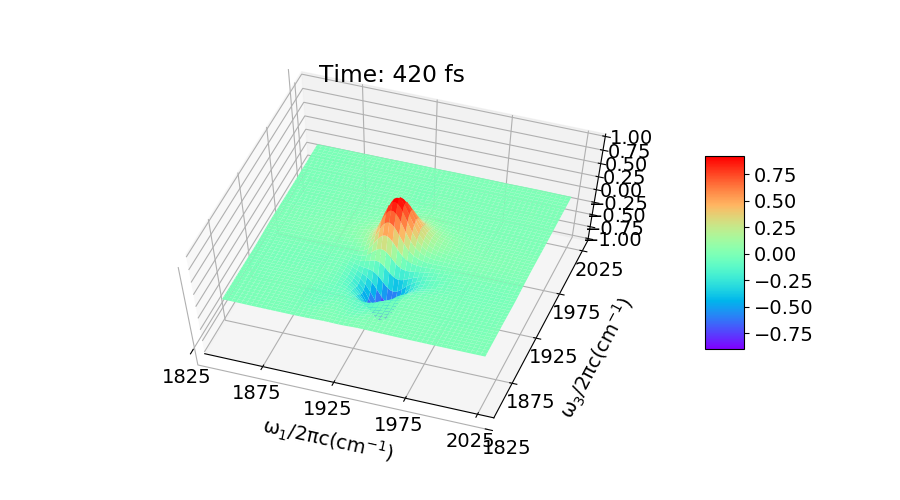

In [4]:
%matplotlib
%matplotlib notebook
def update3d(TimePoint=1):
    plt.close()
    my_fig = plt.figure(figsize=(9,5),num=SOLVENT_NAME)
    ax = surf3d(w1,w3,data[:,:,TimePoint],window_title=SOLVENT_NAME,ax_title='Time: '+str(tau2[TimePoint,0])+' fs',fig=my_fig,azim=azim,elev=elev)

azim = -50
elev = 30
interact_manual(update3d,TimePoint=IntSlider(min=0,max=len(tau2)))

##  Performing Decompositions
A variety of decompositions of the data are possible. Here the PCA is explored. Both the NORMALIZE and N_COMPONENTS variables can be changed to affect the behavior.

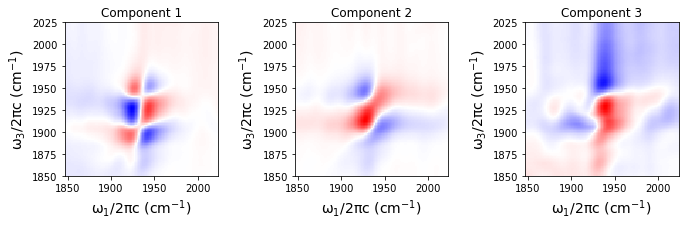

In [5]:
NORMALIZE = True
N_COMPONENTS = 10
comp = getPCAComponents(data,w1,w3,tau2,normalize=NORMALIZE,n_comp=N_COMPONENTS)
proj = getPCAProjections(data,w1,w3,tau2,normalize=NORMALIZE,n_comp=N_COMPONENTS)
%matplotlib inline
show3Components(comp,w1,w3)

## Components in Time
The time variation of the components provide information about how different modes are involved in the dyanmics of the system.

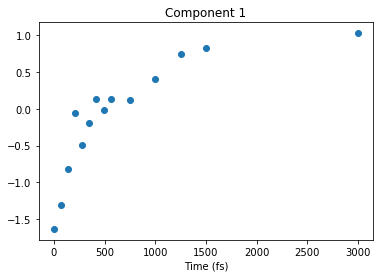

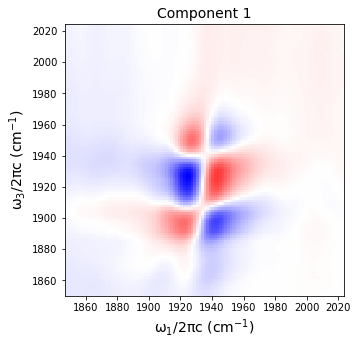

In [6]:
N_COMP = 1
%matplotlib inline
plotContribution(tau2,proj,N_COMP)
showComponent(comp,w1,w3,N_COMP)

## Curve Fitting
Now that we have time series data for each component we can use standard curve fits for linear and non-linear functions to estimate parameters such as time constants. The p0 variable is used to specify the initial guess for a non-linear fit. The T_SCALE parameter provides the units of the time (tau2) variable in fs. Thus a value of 1000 will correspond to ps. *Adjusting this parameter is sometimes necessary to avoid underflow or overflow conditions.*
The list of non-linear fits available here are:
- exponential  ... $A e^{-Bt} + C$
- sine .... $A \sin(Bt) + C$

In [7]:
p0 = .1,.1,.1 
COMP = 1
T_SCALE = 1000

popt, pcov = curve_fit(fits.my_exponential,tau2.ravel()*(1/T_SCALE),proj[:,COMP-1],p0,maxfev=1000)
print('A='+str(popt[0]))
print('B='+str(popt[1]))
print('C='+str(popt[2]))

A=10797.7066117
B=-7.05725091944e-05
C=-10798.3318227


### End of Notebook

In [ ]:
#reset the pyplot backend
%matplotlib
%matplotlib notebook